# STM Transit Delay Feature Engineering and Data Preprocessing

This notebook preprocesses data about STM trip updates and historical weather data.

## Data Description

`trip_id` unique identifier of a trip<br>
`route_id` bus or metro line<br>
`stop_id` stop number<br>
`stop_lat`stop latitude<br>
`stop_lon`stop longitude<br>
`stop_sequence` sequence of the stop, for ordering<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false<br>
`realtime_arrival_time` actual arrival time, in milliseconds<br>
`scheduled_arrival_time` planned arrival time, in milliseconds<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code<br>

## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import sys

In [102]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import LOCAL_TIMEZONE, WEATHER_CODES

In [103]:
# Load data
df = pd.read_csv('../data/stm_weather_merged.csv')

## Feature Engineering

### Delay

In [105]:
# Convert real and scheduled timestamps
df['realtime_arrival_time'] = pd.to_datetime(df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
df['scheduled_arrival_time'] = pd.to_datetime(df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [106]:
# Calculate delay in seconds (real - scheduled)
df['delay'] = (df['realtime_arrival_time'] - df['scheduled_arrival_time']).dt.total_seconds()

In [112]:
# Convert arrival times to local timezone
df['realtime_arrival_time'] = df['realtime_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df['scheduled_arrival_time'] = df['scheduled_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df.head()

,trip_id,route_id,stop_id,stop_lat,stop_lon,stop_sequence,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,delay
0,285028348,189,54433,45.617546,-73.507835,20,1,2025-04-23 01:05:18-04:00,2025-04-23 01:05:08-04:00,4.5,0.0,9.5,0.0,10.0
1,285028348,189,54444,45.621630,-73.505533,21,1,2025-04-23 01:05:51-04:00,2025-04-23 01:05:51-04:00,4.5,0.0,9.5,0.0,0.0
2,285028348,189,54445,45.624606,-73.503332,22,1,2025-04-23 01:06:25-04:00,2025-04-23 01:06:25-04:00,4.5,0.0,9.5,0.0,0.0
3,285028348,189,54451,45.626270,-73.501486,23,1,2025-04-23 01:06:46-04:00,2025-04-23 01:06:46-04:00,4.5,0.0,9.5,0.0,0.0
4,285028348,189,54456,45.628078,-73.499449,24,1,2025-04-23 01:07:09-04:00,2025-04-23 01:07:09-04:00,4.5,0.0,9.5,0.0,0.0


In [107]:
df['delay'].describe()

count    1.944301e+06
mean     6.489847e+01
std      3.708955e+02
min     -8.377000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      1.200000e+01
max      3.464900e+04
Name: delay, dtype: float64

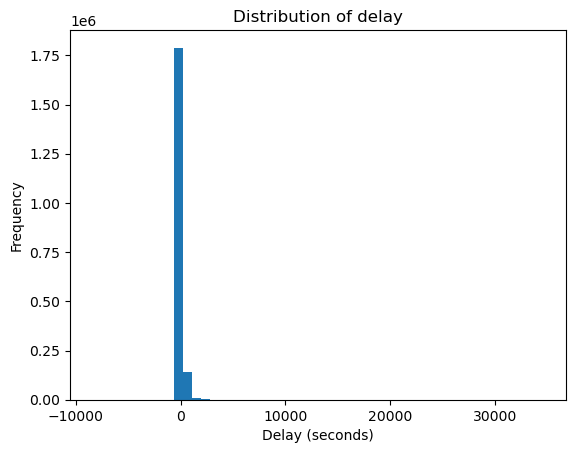

In [108]:
# Plot distribution
plt.hist(df['delay'], bins=50)
plt.title('Distribution of delay')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_hist.png', bbox_inches='tight')
plt.show()


The plot shows there are some massive delays, which could affect the model performance. It's good to see that most trips have no delays.

In [115]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [116]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [117]:
# Get outliers
df[outlier_mask]

,trip_id,route_id,stop_id,stop_lat,stop_lon,stop_sequence,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,delay
3943,286572115,198,61662,45.446593,-73.601897,1,1,2025-04-23 01:03:57-04:00,2025-04-23 01:24:00-04:00,4.5,0.0,9.5,0.0,-1203.0
3944,286572115,198,56986,45.434693,-73.602874,2,1,2025-04-23 01:08:49-04:00,2025-04-23 01:28:59-04:00,4.5,0.0,9.5,0.0,-1210.0
3945,286572115,198,57086,45.432102,-73.606890,3,1,2025-04-23 01:09:50-04:00,2025-04-23 01:30:00-04:00,4.5,0.0,9.5,0.0,-1210.0
3999,284728005,31,50314,45.556953,-73.668029,1,1,2025-04-23 02:44:42-04:00,2025-04-23 00:49:00-04:00,4.0,0.0,11.0,0.0,6942.0
4000,284728005,31,54169,45.555065,-73.670904,2,1,2025-04-23 02:46:14-04:00,2025-04-23 00:50:32-04:00,4.0,0.0,11.0,0.0,6942.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937215,283609230,33,53432,45.577429,-73.515425,59,1,2025-04-27 02:25:19-04:00,2025-04-27 01:00:50-04:00,3.0,0.8,16.1,53.0,5069.0
1937216,283609230,33,53440,45.578947,-73.513489,60,1,2025-04-27 02:26:02-04:00,2025-04-27 01:01:33-04:00,3.0,0.8,16.1,53.0,5069.0
1937217,283609230,33,53921,45.580640,-73.512003,61,1,2025-04-27 02:26:40-04:00,2025-04-27 01:02:11-04:00,3.0,0.8,16.1,53.0,5069.0
1937218,283609230,33,53479,45.581904,-73.510886,62,1,2025-04-27 02:27:09-04:00,2025-04-27 01:02:40-04:00,3.0,0.8,16.1,53.0,5069.0


In [118]:
# Get proportion of outliers
print(f'{(outlier_mask.sum() / len(df)):.2%}')

0.73%


In [125]:
# Remove outliers
df = df[~outlier_mask]

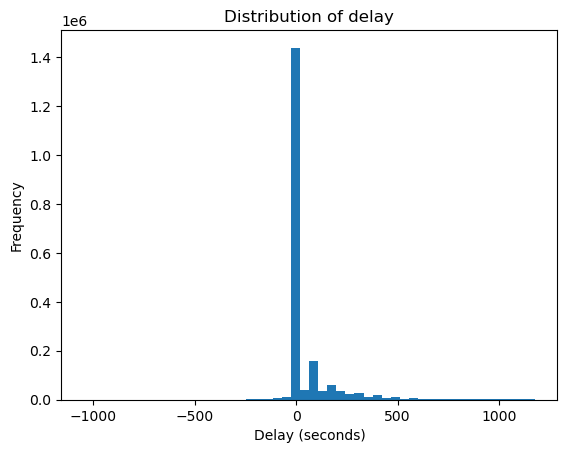

In [126]:
# Plot distribution again
plt.hist(df['delay'], bins=50)
plt.title('Distribution of delay')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_hist2.png', bbox_inches='tight')
plt.show()

### Other features

In [127]:
# Sort values by stop sequence
df = df.sort_values(by=['trip_id', 'route_id', 'stop_sequence'])

In [128]:
# Reset stop sequences (some stops are missing)
df['stop_sequence'] = df.groupby(['trip_id', 'route_id']).cumcount() + 1

In [129]:
# Calculate trip progress percentage
total_stops = df.groupby(['trip_id', 'route_id'])['stop_id'].transform('count')
df['trip_progress_pct'] = df['stop_sequence'] / total_stops

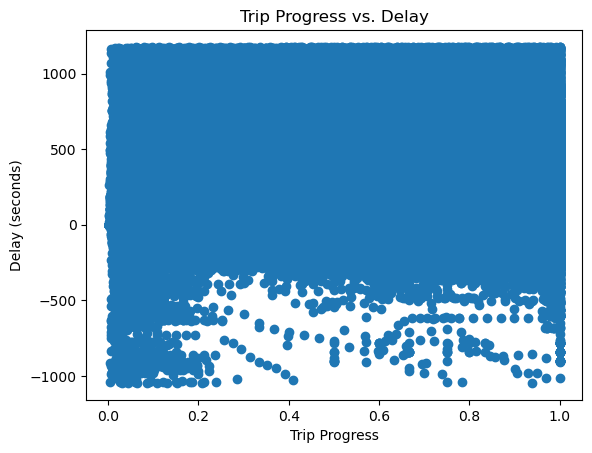

In [130]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress_pct'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

Interpret plot

In [131]:
# Convert datetime to day and hour
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour

In [132]:
# Get average delay by stop, day and hour
stop_hour_avg_delay = df.groupby(['stop_id', 'day', 'hour'])['delay'].mean().reset_index()
stop_hour_avg_delay = stop_hour_avg_delay.rename(columns={'delay': 'historical_avg_delay'})
df = df.merge(stop_hour_avg_delay, on=['stop_id', 'day', 'hour'], how='left')
df.head()

,trip_id,route_id,stop_id,stop_lat,stop_lon,stop_sequence,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,delay,trip_progress_pct,day,hour,historical_avg_delay
0,283551791,51,50110,45.454203,-73.641481,1,1,2025-04-26 05:17:00-04:00,2025-04-26 05:17:00-04:00,8.5,0.7,10.5,53.0,0.0,0.02,5,5,40.666667
1,283551791,51,53792,45.455601,-73.640855,2,1,2025-04-26 05:17:33-04:00,2025-04-26 05:17:33-04:00,8.5,0.7,10.5,53.0,0.0,0.04,5,5,44.500000
2,283551791,51,50766,45.456750,-73.640602,3,1,2025-04-26 05:18:00-04:00,2025-04-26 05:18:00-04:00,8.5,0.7,10.5,53.0,0.0,0.06,5,5,44.500000
3,283551791,51,50716,45.457449,-73.642413,4,1,2025-04-26 05:19:00-04:00,2025-04-26 05:19:00-04:00,8.5,0.7,10.5,53.0,0.0,0.08,5,5,44.500000
4,283551791,51,50648,45.458560,-73.645283,5,1,2025-04-26 05:19:51-04:00,2025-04-26 05:19:51-04:00,8.5,0.7,10.5,53.0,0.0,0.10,5,5,44.500000


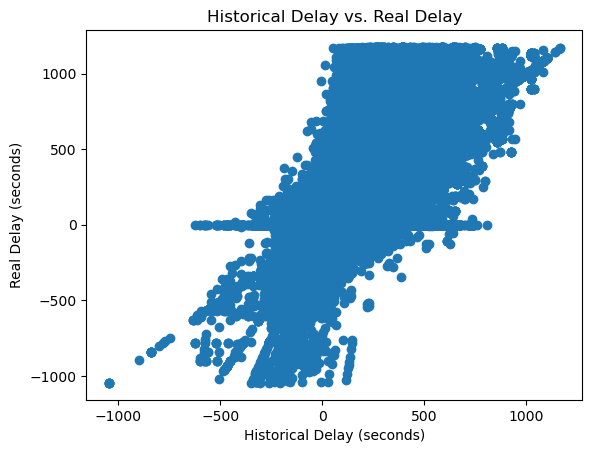

In [133]:
# Plot historical delay vs real delay
plt.scatter(x=df['historical_avg_delay'], y=df['delay'])
plt.title('Historical Delay vs. Real Delay')
plt.xlabel('Historical Delay (seconds)')
plt.ylabel('Real Delay (seconds)')
plt.savefig('../images/hist_vs_real_delay.png', bbox_inches='tight')
plt.show()

Interpret plot

## Data Preprocessing

### Encode Datetime

In [134]:
# Get day and hour from scheduled time
df['sch_day'] = df['scheduled_arrival_time'].dt.day_of_week
df['sch_hour'] = df['scheduled_arrival_time'].dt.hour

In [135]:
# Use Cyclical Encoding for day and hour, as it's more suitable for time-related features
# And the model can "understand" the wrap-around
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

df['sch_day_sin'] = np.sin(2 * np.pi * df['sch_day'] / 7)
df['sch_day_cos'] = np.cos(2 * np.pi * df['sch_day'] / 7)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sch_hour_sin'] = np.sin(2 * np.pi * df['sch_hour'] / 24)
df['sch_hour_cos'] = np.cos(2 * np.pi * df['sch_hour'] / 24)

In [136]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [137]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

### Use Label Encoding for route_id and stop_id

In [138]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [139]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Convert weathercode Into Categories

In [140]:
# Create weather code mapping
weathercodes = df['weathercode'].sort_values().unique()
condition_list = []
label_list = []

for code in weathercodes:
  condition_list.append(df['weathercode'] == code)
  label_list.append(WEATHER_CODES[code])

In [141]:
# Create categories
df['weather'] = np.select(condition_list, label_list, default='Unknown')

In [142]:
df['weather'].value_counts()

weather
Overcast            958451
Clear sky           538869
Partly cloudy       157241
Light drizzle       133719
Slight rain          52516
Moderate drizzle     40495
Mainly clear         30381
Dense drizzle        18466
Moderate rain           23
Name: count, dtype: int64

In [144]:
# Collapsing categories to 6 max
df['weather'] = np.where(df['weather'].isin(['Light drizzle', 'Moderate drizzle', 'Dense drizzle']), 'Drizzle', df['weather'])
df['weather'] = np.where(df['weather'].isin(['Slight rain', 'Moderate rain']), 'Rain', df['weather'])
df['weather'].value_counts()

weather
Overcast         958451
Clear sky        538869
Drizzle          192680
Partly cloudy    157241
Rain              52539
Mainly clear      30381
Name: count, dtype: int64

In [145]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['weather'], drop_first=True, dtype='int64', prefix='weather')
df = df.drop(['weathercode', 'weather'], axis=1).join(one_hot)

## Export Data

In [94]:
df.columns

Index(['trip_id', 'route_id', 'stop_id', 'stop_lat', 'stop_lon',
       'stop_sequence', 'wheelchair_boarding', 'realtime_arrival_time',
       'scheduled_arrival_time', 'temperature', 'precipitation', 'windspeed',
       'delay', 'trip_progress_pct', 'day', 'hour', 'historical_avg_delay',
       'delay_was_clipped', 'sch_day', 'sch_hour', 'day_sin', 'day_cos',
       'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 'sch_hour_sin',
       'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'weather_Drizzle',
       'weather_Mainly clear', 'weather_Overcast', 'weather_Partly cloudy',
       'weather_Slight rain', 'pca_coords'],
      dtype='object')

In [95]:
# Keep encoded columns and reorder them
df = df[['route_id', 'stop_id', 'pca_coords', 'stop_sequence', 'trip_progress_pct',
  		'wheelchair_boarding', 'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 
  		'sch_hour_sin', 'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'historical_avg_delay', 'delay_was_clipped',
  		'temperature', 'precipitation', 'windspeed', 'weather_Drizzle',
       'weather_Mainly clear', 'weather_Overcast', 'weather_Partly cloudy',
       'weather_Slight rain' , 'delay']]

In [96]:
# Export encoders
encoders = {
  'le_route': le_route,
  'le_stop': le_stop
}
with open('../models/label_encoders.pickle', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [97]:
# Export scaler
with open('../models/coord_scaler.pickle', 'wb') as handle:
	pickle.dump(scaler_coord, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
# Export coordinates PCA
with open('../models/coord_pca.pickle', 'wb') as handle:
	pickle.dump(pca_coords, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184739 entries, 0 to 2184738
Data columns (total 27 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   route_id               int64  
 1   stop_id                int64  
 2   pca_coords             float64
 3   stop_sequence          int64  
 4   trip_progress_pct      float64
 5   wheelchair_boarding    int64  
 6   day_sin                float64
 7   day_cos                float64
 8   sch_day_sin            float64
 9   sch_day_cos            float64
 10  hour_sin               float64
 11  hour_cos               float64
 12  sch_hour_sin           float64
 13  sch_hour_cos           float64
 14  is_weekend             int64  
 15  is_peak_hour           int64  
 16  historical_avg_delay   float64
 17  delay_was_clipped      int64  
 18  temperature            float64
 19  precipitation          float64
 20  windspeed              float64
 21  weather_Drizzle        int64  
 22  weather_Mainly cle

In [100]:
# Export dataframe
df.to_csv('../data/preprocessed.csv', index=False)

## End